# Интернет-магазин «Стримчик»

В нашем распоряжении данные об играх за последние 30 лет: название игры, платформа, жанр, год релиза, количество проданных копий в различных регионах, оценки пользователей и критиков, возрастной рейтинг.

Нам нужно определить потенциально прибыльные игровые платформы, найти самые популярные жанры среди геймеров из разных регионов, проверить две гипотезы.

**Цели исследования:** выявить определяющие успешность игры закономерности, проверить две гипотезы:

- Средние пользовательские рейтинги платформ Xbox One и PC одинаковые
- Пользовательские рейтинги жанров Action и Sports разные

**Ход исследования:**

1. Обзор данных
2. Предобработка
3. Исследовательский анализ
4. Построение портрета пользователя каждого региона
5. Проверка гипотез

In [1]:
# Импортируем нужные нам библиотеки

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats as st

#### Загрузка данных

In [2]:
data = pd.read_csv('/datasets/games.csv')

# Выводим общую информацию

data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


##### Промежуточный вывод по этапу загрузки данных

Всего в таблице 16715 строк, в глаза бросается огромное количество пропусков в столбцах с оценками критиков и пользователей и с возрастным рейтингом, названия столбцов не соответствуют общепринятым стандартам, нужно будет изменить их, также нужно будет поменять тип данных в столбце с годом релиза и оценкой пользователей.

#### Предобработка данных

Для начала подправим названия столбцов:

In [3]:
# Приводим названия столбцов к нижнему регистру

data.columns = data.columns.str.lower()
data.columns

Index(['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating'],
      dtype='object')

Проверим данные на наличие явных и неявных дубликатов:

In [4]:
print('Количество явных дубликатов:', data.duplicated().sum())

data[data.loc[:, 'name':'year_of_release'].duplicated() == 1]

Количество явных дубликатов: 0


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
14244,NaN,GEN,1993.0,NaN,0.0,0.00,0.03,0.0,NaN,NaN,NaN
16230,Madden NFL 13,PS3,2012.0,Sports,0.0,0.01,0.00,0.0,83.0,5.5,E


Явных дубликатов не обнаружено, но есть 2 игры, продажи которых были посчитаны по 2 раза, так как название, платформа и год релиза у них одинаковые. Удалим эти строки:

In [5]:
data = data.drop(labels=data[data.loc[:, 'name':'year_of_release'].duplicated() == 1].index.values.tolist(), axis=0)

# data.shape[0]

Изменим тип данных в столбце с годом релиза на целочисленный и с оценкой пользователей на вещественный

In [6]:
# Создаем список индексов, где в строках нет пропусков и значения 'tbd', затем с помощью индексации 
# изменяем тип данных

score = data.query('user_score != "tbd" and user_score.isna() == 0').index.values.tolist()
data.loc[score, 'user_score'] = data.loc[score, 'user_score'].astype(float)

year = data.query('year_of_release.isna() == 0').index.values.tolist()
data.loc[year, 'year_of_release'] = data.loc[year, 'year_of_release'].astype(str)
data.loc[year, 'year_of_release'] = data.loc[year, 'year_of_release'].astype(float)
data.loc[year, 'year_of_release'] = data.loc[year, 'year_of_release'].astype(int)

data.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


Теперь посмотрим общее количество пропусков:

In [7]:
# Смотрим количесвто пропусков в каждом столбце

data.isna().sum()

name                  1
platform              0
year_of_release     269
genre                 1
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8577
user_score         6700
rating             6765
dtype: int64

По 1 пропущенному значению в столбце с жанром и названием игры, 269 пропусков в столбце с годом релиза, огромное количество пропусков в столбцах с оценкой критиков и пользователей и возрастным рейтингом. Пропуски в  этих трех столбцах оставим как есть, так как они занимают почти половину своих столбцов и их заполнение синтетическими данными приведет к сильному искажению реальной картины. Заполнить пропуски в  столбце с годом релиза не предоставляется возможным. Посмотрим что из себя представляет строка без названия игры:

In [8]:
data.query('name.isna() == 1')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993,NaN,1.78,0.53,0.0,0.08,NaN,NaN,NaN


В этой строке пропущены оценки, рейтинги, год релиза и название игры, удалим эту строку

In [9]:
data = data.query('name.isna() == 0')

# data.shape[0]

Посмотрим на пропуски в столбце с годом релиза:

In [10]:
display(data.query('year_of_release.isna() == 1').head(10))

print('Доля пропусков в столбце с годом релиза', 
      round(data.query('year_of_release.isna() == 1')['platform'].count()/data.shape[0]*100, 2), '%')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
183,Madden NFL 2004,PS2,NaN,Sports,4.26,0.26,0.01,0.71,94.0,8.5,E
377,FIFA Soccer 2004,PS2,NaN,Sports,0.59,2.36,0.04,0.51,84.0,6.4,E
456,LEGO Batman: The Videogame,Wii,NaN,Action,1.80,0.97,0.00,0.29,74.0,7.9,E10+
475,wwe Smackdown vs. Raw 2006,PS2,NaN,Fighting,1.57,1.02,0.00,0.41,NaN,NaN,NaN
609,Space Invaders,2600,NaN,Shooter,2.36,0.14,0.00,0.03,NaN,NaN,NaN
627,Rock Band,X360,NaN,Misc,1.93,0.33,0.00,0.21,92.0,8.2,T
657,Frogger's Adventures: Temple of the Frog,GBA,NaN,Adventure,2.15,0.18,0.00,0.07,73.0,tbd,E
678,LEGO Indiana Jones: The Original Adventures,Wii,NaN,Action,1.51,0.61,0.00,0.21,78.0,6.6,E10+
719,Call of Duty 3,Wii,NaN,Shooter,1.17,0.84,0.00,0.23,69.0,6.7,T
805,Rock Band,Wii,NaN,Misc,1.33,0.56,0.00,0.20,80.0,6.3,T


Доля пропусков в столбце с годом релиза 1.61 %


Доля пропусков составляет 1.61 % от всего датафрейма, в некоторых строках также присутствуют пропуски в столбцах с оценками и возрастным рейтингом, поэтому их можно удалить:

In [11]:
data = data.query('year_of_release.isna() == 0')

# data.shape[0]

Рассмотрим столбец с возрастным рейтингом:

In [12]:
data['rating'].unique()

array(['E', nan, 'M', 'T', 'E10+', 'K-A', 'AO', 'EC', 'RP'], dtype=object)

Возрастной рейтинг ESRB определяется только для США и Канады, поэтому для остальных регионов  рейтинг не определен, рейтинг K-A (Kids to Adults) устарел и его объединил с рейтингом E (Everyone), поэтому пропуски в этом столбце заполним значением "no rating" и заменим все K-A на E

In [13]:
data['rating'] = data['rating'].fillna('нет рейтинга')
data['rating'] = data['rating'].replace('K-A', 'E')

Рассмотрим столбец с оценкой пользователей

In [14]:
data['user_score'].unique()

array([8.0, nan, 8.3, 8.5, 6.6, 8.4, 8.6, 7.7, 6.3, 7.4, 8.2, 9.0, 7.9,
       8.1, 8.7, 7.1, 3.4, 5.3, 4.8, 3.2, 8.9, 6.4, 7.8, 7.5, 2.6, 7.2,
       9.2, 7.0, 7.3, 4.3, 7.6, 5.7, 5.0, 9.1, 6.5, 'tbd', 8.8, 6.9, 9.4,
       6.8, 6.1, 6.7, 5.4, 4.0, 4.9, 4.5, 9.3, 6.2, 4.2, 6.0, 3.7, 4.1,
       5.8, 5.6, 5.5, 4.4, 4.6, 5.9, 3.9, 3.1, 2.9, 5.2, 3.3, 4.7, 5.1,
       3.5, 2.5, 1.9, 3.0, 2.7, 2.2, 2.0, 9.5, 2.1, 3.6, 2.8, 1.8, 3.8,
       0.0, 1.6, 9.6, 2.4, 1.7, 1.1, 0.3, 1.5, 0.7, 1.2, 2.3, 0.5, 1.3,
       0.2, 0.6, 1.4, 0.9, 1.0, 9.7], dtype=object)

Значение tbd означает to be determined, что рейтинг не определен и  будет обозначен в ближайшее время, поэтому это значение можно считать пропущенным и везде заменить на NaN:

In [15]:
data['user_score'] = data['user_score'].replace('tbd', np.nan)

data['user_score'].unique()

array([8. , nan, 8.3, 8.5, 6.6, 8.4, 8.6, 7.7, 6.3, 7.4, 8.2, 9. , 7.9,
       8.1, 8.7, 7.1, 3.4, 5.3, 4.8, 3.2, 8.9, 6.4, 7.8, 7.5, 2.6, 7.2,
       9.2, 7. , 7.3, 4.3, 7.6, 5.7, 5. , 9.1, 6.5, 8.8, 6.9, 9.4, 6.8,
       6.1, 6.7, 5.4, 4. , 4.9, 4.5, 9.3, 6.2, 4.2, 6. , 3.7, 4.1, 5.8,
       5.6, 5.5, 4.4, 4.6, 5.9, 3.9, 3.1, 2.9, 5.2, 3.3, 4.7, 5.1, 3.5,
       2.5, 1.9, 3. , 2.7, 2.2, 2. , 9.5, 2.1, 3.6, 2.8, 1.8, 3.8, 0. ,
       1.6, 9.6, 2.4, 1.7, 1.1, 0.3, 1.5, 0.7, 1.2, 2.3, 0.5, 1.3, 0.2,
       0.6, 1.4, 0.9, 1. , 9.7])

Проверим, как распределены пропуски в столбцах с оценками критиков и пользователей:

In [16]:
data.query('user_score.isna() == 1 and critic_score.isna() == 1')['platform'].count()

7892

Как и ожидалось, пропуски здесь взаимосвязаны: практически все пропуски находятся в одних и тех же строках. Возможно эти игры просто не были оценены ввиду своей непопулярности, а возможно релиз игры состоялся недавно и она не успела получить отзывы. Но количество пропусков очень большое, данные по количеству продаж на разных платформах в этих строках могут быть полезны для исследования, поэтому оставим их.

Посмотрим, сколько пропусков осталось после их обработки и заодно посмотрим как изменился тип данных в столбцах:

In [17]:
print(data.isna().sum(), '\n')

data.info()

name                  0
platform              0
year_of_release       0
genre                 0
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8461
user_score         8981
rating                0
dtype: int64 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16443 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16443 non-null  object 
 1   platform         16443 non-null  object 
 2   year_of_release  16443 non-null  object 
 3   genre            16443 non-null  object 
 4   na_sales         16443 non-null  float64
 5   eu_sales         16443 non-null  float64
 6   jp_sales         16443 non-null  float64
 7   other_sales      16443 non-null  float64
 8   critic_score     7982 non-null   float64
 9   user_score       7462 non-null   float64
 10  rating           16443 non-null  object 
dtypes: float6

Теперь создадим новый столбец с общими продажами по всему миру:

In [18]:
# Создаем новый столбец для дальнейшего удобства

data['sales'] = data.loc[:,['na_sales','eu_sales', 'jp_sales', 'other_sales']].sum(axis=1)

data.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,нет рейтинга,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,нет рейтинга,31.38


Перейдем к обработке аномальных значений:

In [19]:
# Выводим характеристику каждого столбца

print(data['na_sales'].describe(),
      data['eu_sales'].describe(),
      data['jp_sales'].describe(),
      data['other_sales'].describe(),
      data['sales'].describe(), sep='\n\n')

count    16443.000000
mean         0.264028
std          0.818400
min          0.000000
25%          0.000000
50%          0.080000
75%          0.240000
max         41.360000
Name: na_sales, dtype: float64

count    16443.000000
mean         0.145939
std          0.506731
min          0.000000
25%          0.000000
50%          0.020000
75%          0.110000
max         28.960000
Name: eu_sales, dtype: float64

count    16443.000000
mean         0.078492
std          0.311109
min          0.000000
25%          0.000000
50%          0.000000
75%          0.040000
max         10.220000
Name: jp_sales, dtype: float64

count    16443.000000
mean         0.047597
std          0.188011
min          0.000000
25%          0.000000
50%          0.010000
75%          0.030000
max         10.570000
Name: other_sales, dtype: float64

count    16443.000000
mean         0.536055
std          1.558828
min          0.000000
25%          0.060000
50%          0.170000
75%          0.470000
max        

Видно, что половина продаж в регионах исчитывается всего десятками тысяч копий, тогда как миллионами копий исчитываются лишь несколько десятков игр. Аномальных значений нет. Общие продажи около 30% от общего числа игр не превышают 100 тыс. копий.

##### Промежуточный вывод по этапу предобработки данных

Названия столбцов были приведены к нижнему регистру, был изменен тип данных в столбце с годом релиза на целочисленный (так как год это целое число) и в столбце с оценкой пользователей на вещественный (изначально все значения в этом столбце были строчными). Было обнаружено огромное количество пропусков:

- столбец с названием игры - 1 пропущенное значение, возможно у игры просто нет названия, или же это авторская модификация, которая была представлена в виде отдельной игры без официального названия. Строка удалена

- столбец с годом релиза - 269 пропусков, скорее всего у игры нет точной даты выхода или же ее просто забыли указать. Все строки удалены

- столбец с жанром - 1 пропущенное значение, в той же строке где у игры нет названия, причины пропущенного значения скоре всего такие же как и у названия. Строка была удалена

- столбцы с оценками критиков и пользователей - 8677 и 6700 пропусков соответственно, возможно игра была просто не оценена или ее релиз состоялся недавно и она не получила отзывов. В столцбе с оценкой пользователей значение tbd (to be determined) было заменено на NaN, так как tbd означает, что оценки нет, но в скором времени она появится, возможно игра еще не вышла, но открылись предзаказы на нее. Пропуски не были заполнены, так как они составляют почти половину столбца и заполнение их синтетическими данными приведет к искажению результата исследования

- столбец возрастным рейтингом - 6765 пропусков, это связано с тем, что возрастной рейтинг ESRB определяется только в США и Канаде, поэтому для остальных регионов он не определен, и пропущенные значения были заменены на "no_rating"

Аномальные значения не были обнаружены. Был создан новый столбец с общим количеством продаж во всех регионах. В общей сложности было удалено 272 строки

#### Исследовательский анализ данных

Узнаем, сколько игр выходило в разные годы:

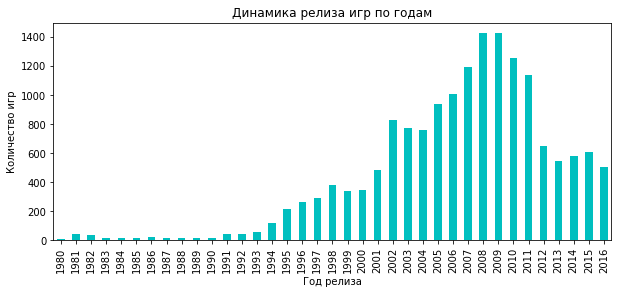

In [21]:
# Строим столбчатую диаграмму

# data['year_of_release'].value_counts(ascending=True).plot(kind='barh', figsize=(5, 8));

data.groupby('year_of_release')['name'].count().plot(kind='bar', figsize=(10, 4), color='c')
plt.title('Динамика релиза игр по годам')
plt.xlabel('Год релиза')
plt.ylabel('Количество игр');

До 1994 года выходил совсем мало игр - не больше 50 за год, с 1994 до 2001 был заметен прирост, а после 2001 и до 2009 количество игр стремительно росло, но после этого периода их количество начало уменьшаться.

Теперь посмотрим, как менялись продажи по платформам:

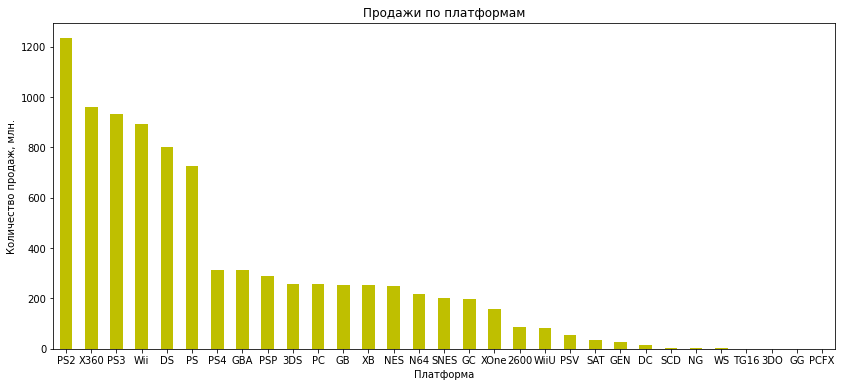

In [22]:
(
data.pivot_table(index='platform', values='sales', aggfunc='sum').sort_values(by='sales', ascending=False)
.plot(kind='bar', figsize=(14, 6), color='y', legend=False, rot=0)
)
plt.title('Продажи по платформам')
plt.xlabel('Платформа')
plt.ylabel('Количество продаж, млн.');

# data.pivot_table(index='platform', values='sales', aggfunc='sum').sort_values(by='sales', ascending=False)

Самое большое количество игр было продано на PS2 - больше 1.2 млрд. копий, следующие за ней идут X360, PS3, Wii, DS и PS соответственно, продажи остальных игровых платформ не превышают 400 млн. копий.

Чтобы определить среднюю продолжительность "жизни" платформы, возьмем данные после 2000 года, так как начиная с этого времени частота выхода игр достаточно высокая.

In [23]:
platform_life = data.query('year_of_release > 2000').pivot_table(index='platform', 
                                                                 values='year_of_release', aggfunc=['max', 'min'])
platform_life['time_life'] = platform_life['max'] - platform_life['min'] + 1
print('Средняя продолжительность жизни платформы:', platform_life['time_life'].median().astype(int), 'лет')

Средняя продолжительность жизни платформы: 7 лет


Одна игровая платформа в среднем держится на плаву около 7 лет

Теперь посмотрим на количество проданных копий для каждой платформы за последние 5 лет

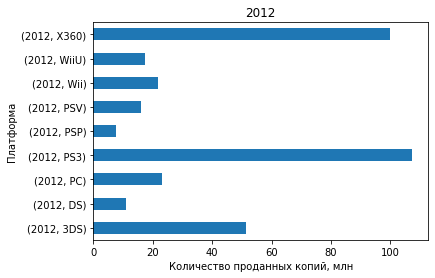

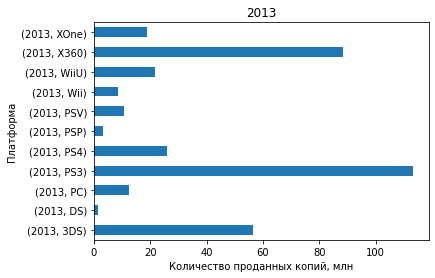

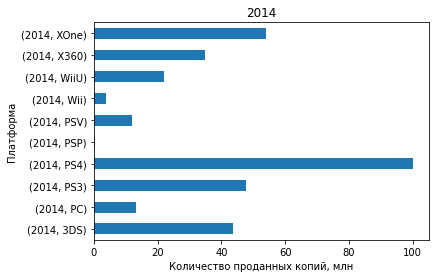

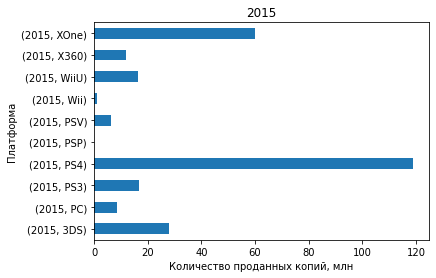

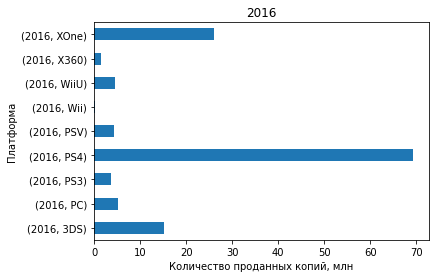

In [26]:
# С помощью цикла проходимся по всем годам и строим для каждого из них
# горизонтальную столбчатую диаграмму

for x in range(2012, 2017):
    (
    data.pivot_table(index=['year_of_release', 'platform'], values='sales', aggfunc='sum')
    .query('year_of_release == @x').plot(kind='barh', title=x, legend=False)
    )
    plt.xlabel('Количество проданных копий, млн')
    plt.ylabel('Платформа')

С 2012 до 2014 года на рынке господствовали консоли PS3, X360 и 3DS. Но после появления PS4 и XOne в 2013 году, все остальные платформы ушли на второй план. Эти две платформы отличаются от предшественников гораздо большей производительностью и комфортом использования. С уверенностью можно сказать, что игры для консолей PS4 и XOne принесут огромную прибыль в 2017 году. Но также немного выделяется консоль 3DS, продажи на эту консоль с 2012 по 2014 год всегда были больше 40 млн., а после в районе 15-25 млн. копий, что тоже является неплохим показателем.

Для верного прогноза на 2017 год нужно анализировать только актуальные данные, исходя из выше сказанного актуальным периодом для исследования будем считать период с 2013 - появление Xbox One и PS4 на рынке,- по 2016 год. Также избавимся от платформ, жизнь которых подошла к концу.

In [27]:
data = data.query('year_of_release > 2012 and platform != ["Wii", "PSP", "DS"]')

data.shape[0]

2135

In [28]:
# Комментарий ревьюера 2
temp1, temp2 = data.sales.sum(), temp[temp.year_of_release > 2012].sales.sum()
temp1, temp2, round((temp2-temp1)/temp2*100, 2)

(1071.9900000000002, 1090.69, 1.71)

Теперь посмотрим на диаграммы размаха по количеству продаж для каждой платформы:

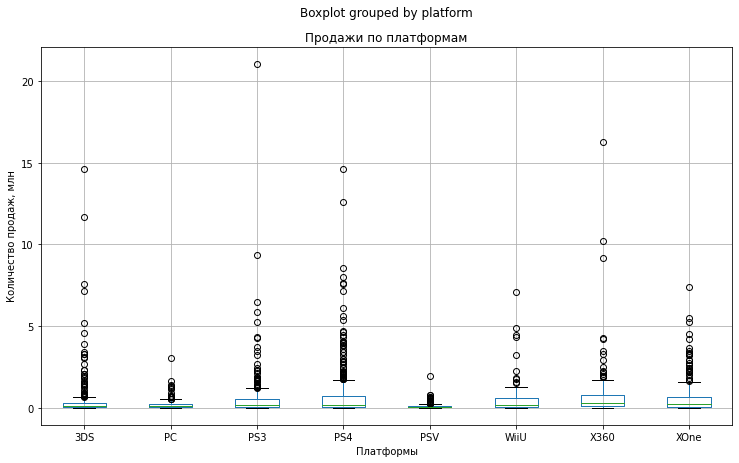

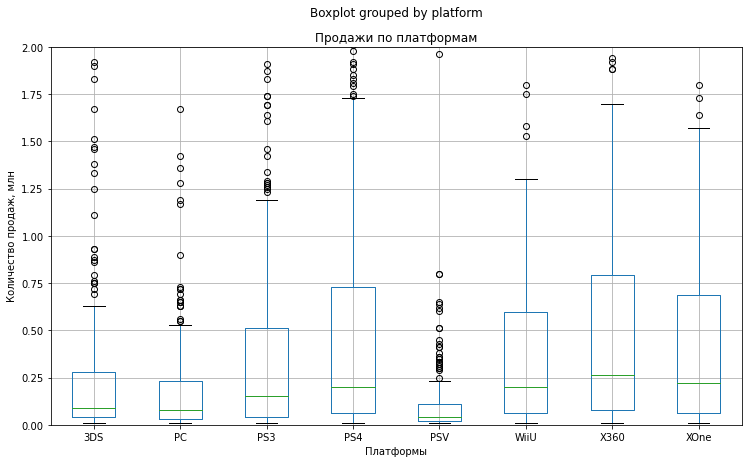

In [29]:
# С помощью цикла проходимся по всем индексам (названиям платформ) сводной таблицы и строим для каждой из них
# диаграмму размаха

#for i in (
#          data.pivot_table(index='platform', values='sales', aggfunc='sum').sort_values(by='sales', ascending=False).head(10)
#          .index.values.tolist()
#         ):
#    data.query('platform == @i').boxplot(column='sales', by='platform')
#    plt.title(i)
#    plt.ylabel('Количество продаж, млн')
#    plt.show();

data.boxplot(column='sales', by='platform', figsize=(12, 7))
plt.title('Продажи по платформам')
plt.xlabel('Платформы')
plt.ylabel('Количество продаж, млн')
plt.show();

data.boxplot(column='sales', by='platform', figsize=(12, 7))
plt.ylim(0, 2)
plt.title('Продажи по платформам')
plt.xlabel('Платформы')
plt.ylabel('Количество продаж, млн')
plt.show();

У всех платформ пределы нормальных значений не превышают 2 млн. У каждой платформы есть игры, продажи которой исчисляются несколькими миллионами копий. Минимальное значение везде равно 0. Можно сделать следующий вывод: разработчики создают огромное количество игр, но большинство из их не "выстреливают": либо игра очень непопулярна, либо это хит, продажи которого составляют более 2 млн. копий.

Теперь узнаем, как влияют на продажи внутри одной популярной платформы отзывы пользователей и критиков.

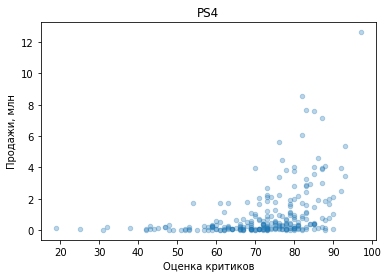

Коэффициент корреляции Пирсона при оценке критиков равен 0.40656790206178095


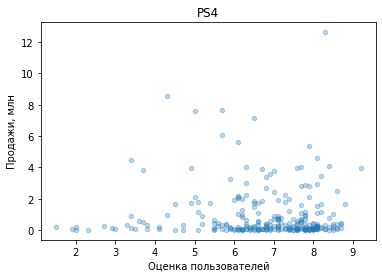

Коэффициент корреляции Пирсона при оценке пользователей равен -0.031957110204556376
____________________________________________________________


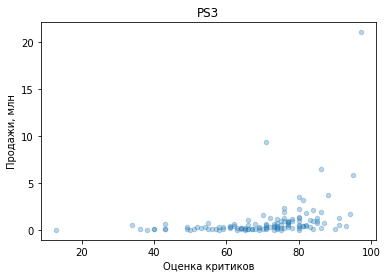

Коэффициент корреляции Пирсона при оценке критиков равен 0.3342853393371919


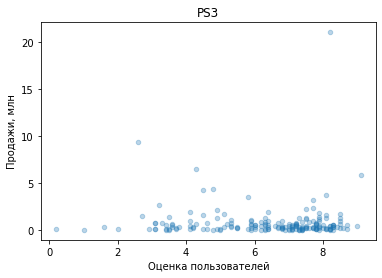

Коэффициент корреляции Пирсона при оценке пользователей равен 0.0023944027357566925
____________________________________________________________


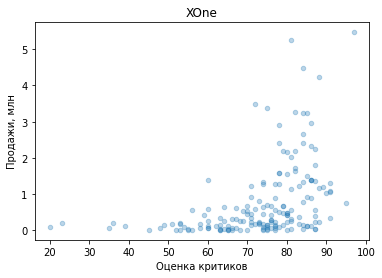

Коэффициент корреляции Пирсона при оценке критиков равен 0.4169983280084017


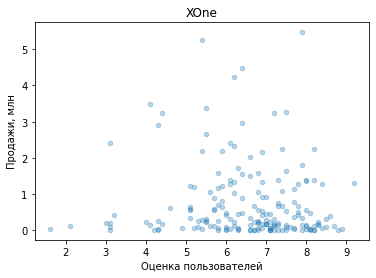

Коэффициент корреляции Пирсона при оценке пользователей равен -0.06892505328279414
____________________________________________________________


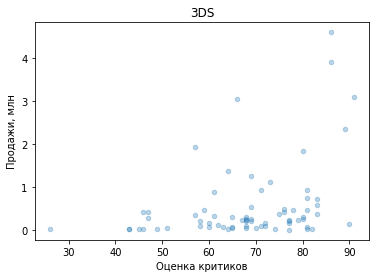

Коэффициент корреляции Пирсона при оценке критиков равен 0.3570566142288103


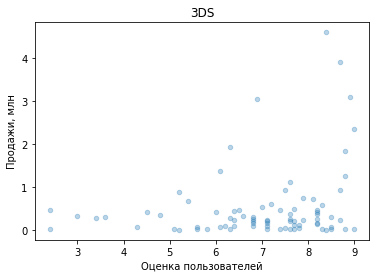

Коэффициент корреляции Пирсона при оценке пользователей равен 0.24150411773563016
____________________________________________________________


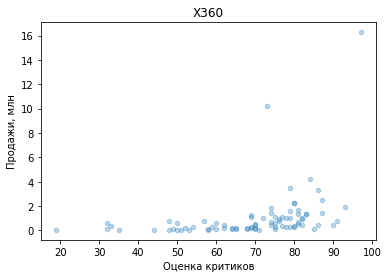

Коэффициент корреляции Пирсона при оценке критиков равен 0.3503445460228664


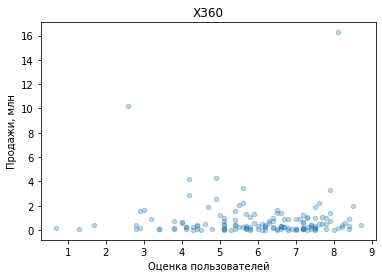

Коэффициент корреляции Пирсона при оценке пользователей равен -0.011742185147181342
____________________________________________________________


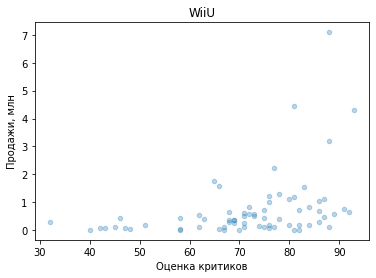

Коэффициент корреляции Пирсона при оценке критиков равен 0.3764149065423912


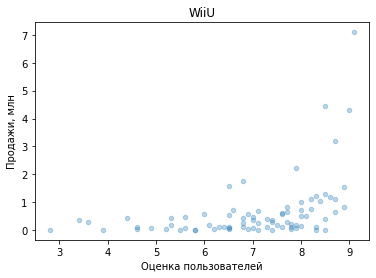

Коэффициент корреляции Пирсона при оценке пользователей равен 0.4193304819266187
____________________________________________________________


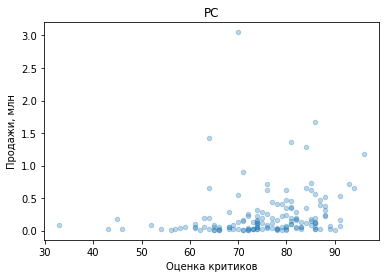

Коэффициент корреляции Пирсона при оценке критиков равен 0.19603028294369382


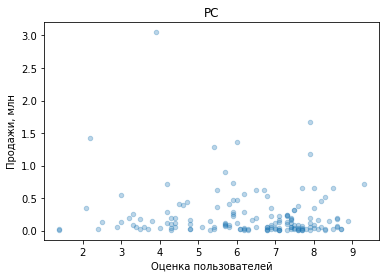

Коэффициент корреляции Пирсона при оценке пользователей равен -0.0938418695247674
____________________________________________________________


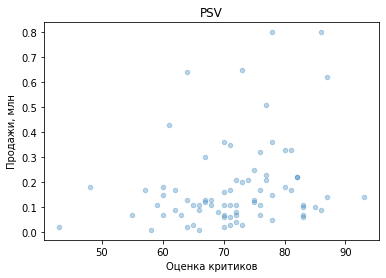

Коэффициент корреляции Пирсона при оценке критиков равен 0.2547423503068656


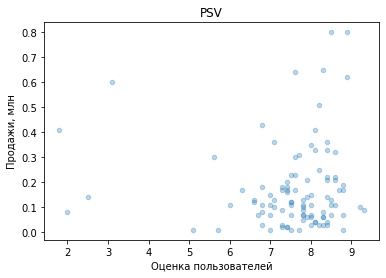

Коэффициент корреляции Пирсона при оценке пользователей равен 0.0009424723319108626
____________________________________________________________


In [30]:
# С помощью цикла проходимся по всем индексам (названиям платформ) сводной таблицы и строим для среза данных по платформе
# диаграмму рассеяния в зависимости от оценки пользователя и критика, и тут же считаем коэффициент корреляции Пирсона

for i in (
          data.pivot_table(index='platform', values='sales', aggfunc='sum').sort_values(by='sales', ascending=False)
          .index.values.tolist()
         ):
    data.query('platform == @i').plot(x='critic_score',
                                      y='sales',
                                      kind='scatter',
                                      alpha=0.3)
    plt.title(i)
    plt.xlabel('Оценка критиков')
    plt.ylabel('Продажи, млн')
    plt.show()
    print('Коэффициент корреляции Пирсона при оценке критиков равен', 
          data.query('platform == @i')['critic_score'].corr(data.query('platform == @i')['sales']))
    
    data.query('platform == @i').plot(x='user_score',
                                      y='sales',
                                      kind='scatter',
                                      alpha=0.3)
    plt.title(i)
    plt.xlabel('Оценка пользователей')
    plt.ylabel('Продажи, млн')
    plt.show()
    print('Коэффициент корреляции Пирсона при оценке пользователей равен', 
          data.query('platform == @i')['user_score']
          .corr(data.query('platform == @i')['sales']))
    
# Для удобства разделяем пары графиков сплошной линией
    
    print(60*'_')

Профили всех графиков похожи. В основном количество продаж исчисляется от 0 до 1 млн. При оценке критиков до 60 рост почти не заметен. Коэффициент корреляции Пирсона говорит о том, что при большей оценке критиков продажи тоже растут, но его значение не превышает 0.5 - средняя корреляция. Этот же коэффициент при оценке пользователей гораздо ближе к 0.1 - очень слабая корреляция, значит их оценки почти не влияют на продажи. Вывод: оценка критиков намного сильнее влияет на количество проданных копий.

Все выше описанные выводы с уверенностью можно спроецировать на остальные платформы, которые не были рассмотрены на этапе исследовательского анализа.

Теперь посмотрим на количество проданных игр по жанрам:

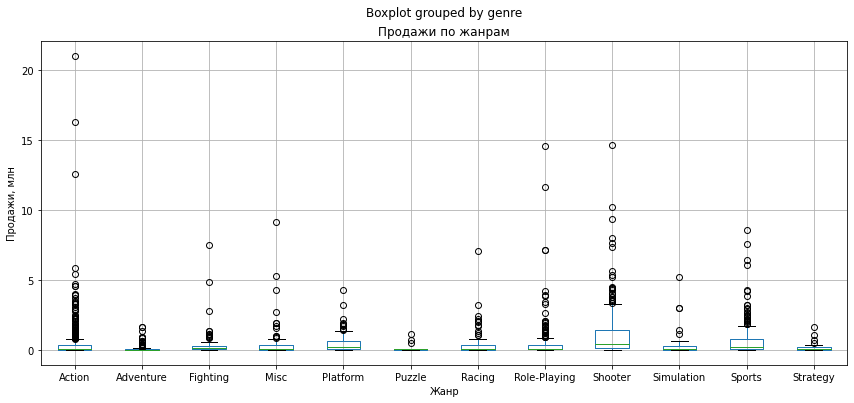

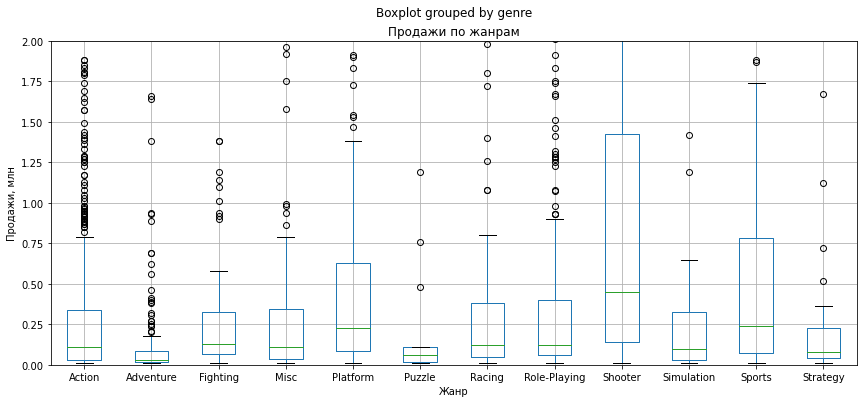

In [31]:
# Создаем свобную таблицу

#data.pivot_table(index='genre', values='sales', aggfunc='sum').sort_values(by='sales', ascending=False)

data.boxplot(column='sales', by='genre', figsize=(14, 6))
plt.title('Продажи по жанрам')
plt.xlabel('Жанр')
plt.ylabel('Продажи, млн')
plt.show();

data.boxplot(column='sales', by='genre', figsize=(14, 6))
plt.ylim(0, 2)
plt.title('Продажи по жанрам')
plt.xlabel('Жанр')
plt.ylabel('Продажи, млн')
plt.show();

Самый популярный жанр это Shooter, дальше за ним идут Sports и Platform, медианные продажи на остальных платформах не превышают 200 тыс. копий, самые непопулярные - Puzzle и Adventure. Это очевидно, ведь игры были созданы в первую очередь для развлечения, для того, чтобы делать вещи, которые невозможно делать в реальной жизни, и в основном для детей. А пазлы не могут похвастаться наличием этих параметров, дети практически никогда не играют в подобный жанр игр, для них это скучно.

##### Промежуточный вывод по этапу исследовательского анализа данных

Было рассмотрено количество игр, выпущенных в разные года и на разных платформах, по этим данным был сделан вывод, что актуальным периодом для исследования является 2013-2016 года. Таблица была отфильтрована по этому параметру, было удалено почти 14000 строк исходного датафрейма. С этими же данными удалились и те, которые содержали в себе информацию о неактуальных игровых платформах. Самые популярные платформы - PS4 и Xbox One. В среднем длительность "жизни" одной игровой платформы равна 7 лет. Актуальными платформами на 2016 год являются PS4 и XOne, их можно отнести к потенциально прибыльным, так как продажи для этих платформ растут начиная с момента их появления на рынке, после этого года все остальные платформы ушли на второй план. На продажи, хоть и несильно, влияют оценки критиков, оценки пользователей почти не имеют веса. Самый популярный жанр это Shooter (медианные продажи ~500 тыс. копий), дальше за ним идут Sports и Platform, медианные продажи на остальных платформах не превышают 200 тыс. копий, самые непопулярные - Puzzle и Adventure.

#### Портреты пользователей каждого региона

Опишем предпочтения пользователей: выведем топ 5 игровых платформ и жанров для каждого региона.

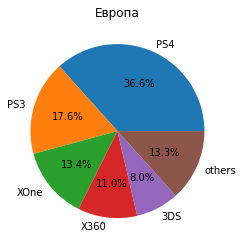

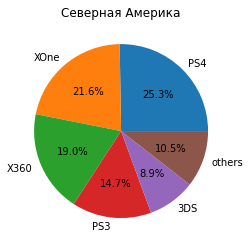

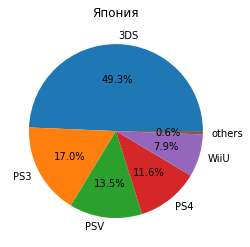

In [32]:
for x in['eu_sales', 'na_sales', 'jp_sales']:
    region = (
         data.pivot_table(index='platform', values=x, aggfunc='sum')
         .sort_values(by=x, ascending=False).reset_index()
         )

# Суммируем данные по жанрам, которые не вошли в топ-5 и обозначем их как others
    
    region.loc[5] = region.loc[5:, x].sum()
    region.loc[5, 'platform'] = 'others'
    region = region.loc[:5]

# С помощью цикла меняем индексы на названия платформ, чтобы при построении круговой диаграммы были видны названия
    
    for i in range(0, 6):
        region.rename(index={i: region.loc[i, 'platform']}, inplace=True)
    region.plot(kind='pie', y=x, autopct='%.1f%%', legend=False)
    if x == 'eu_sales':
        plt.title('Европа')
    if x == 'na_sales':
        plt.title('Северная Америка')
    if x == 'jp_sales':
        plt.title('Япония')
    plt.ylabel('')
    plt.show();

Население Европы составляет ~740 млн. человек. Самой популярной платформой для европейцев явлется PS4. Доля остальных платформ не превышает 18%.

Население Северной Америки составляет ~600 млн. человек. Самая популярная приставка здесь также PS4, но доля продаж XOne и X360 здесь выше чем в Европе - 21.6% и 19 % соответственно, возможно это связано с тем, что это отечественные платформы.

Население Японии составляет ~125 млн. человек, очевидно. В отличие от предыдущих результатов, в этом топе отсутствуют платформы X360 и XOne, вместо них здесь PSV и WiiU. Самой популярной платформой является 3DS, - на нее приходится половина продаж. Интересен тот факт, что все игровые приставки в этом топе разработаны как раз-таки здесь, в Японии. Поэтому доля других платформ здесь очень маленькая - 0.6%.

Теперь взглянем на популярность жанров:

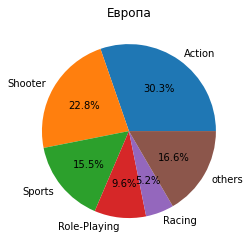

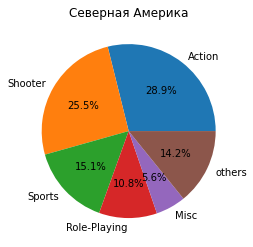

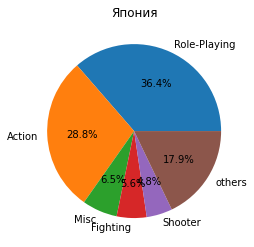

In [33]:
for x in['eu_sales', 'na_sales', 'jp_sales']:
    region = (
         data.pivot_table(index='genre', values=x, aggfunc='sum')
         .sort_values(by=x, ascending=False).reset_index()
         )

# Суммируем данные по жанрам, которые не вошли в топ-5 и обозначем их как others
    
    region.loc[5] = region.loc[5:, x].sum()
    region.loc[5, 'genre'] = 'others'
    region = region.loc[:5]

# С помощью цикла меняем индексы на названия жанра, чтобы при построении круговой диаграммы были видны жанры
    
    for i in range(0, 6):
        region.rename(index={i: region.loc[i, 'genre']}, inplace=True)
    region.plot(kind='pie', y=x, autopct='%.1f%%', legend=False)
    if x == 'eu_sales':
        plt.title('Европа')
    if x == 'na_sales':
        plt.title('Северная Америка')
    if x == 'jp_sales':
        plt.title('Япония')
    plt.ylabel('')
    plt.show();

В Европе самым популярным жанром является Action, как и в Северной Америке, топ-4 у них схож, даже по долям продаж, а последнюю строчку в топе Европы занимает Racing вместо Misc, также нельзя не отметить существенную долю других жанров во всех регионах. В Японии наблюдается другая картина: самый популярный жанр - Role-Playing - 36.4%, на втором месте Action - 28.8%, остальные три жанра занимают примерно одинаковую долю.

Теперь посмотрим, как возрастыне рейтинги влияют на продажи в тех же регионах:

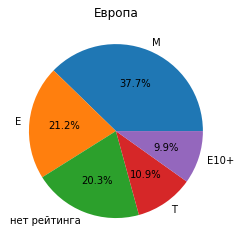

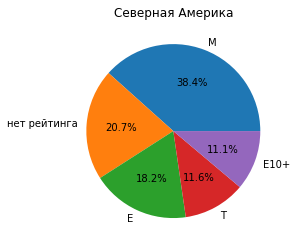

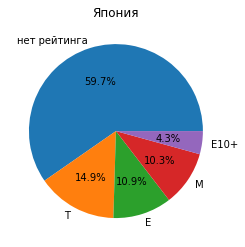

In [37]:
for x in ['eu_sales', 'na_sales', 'jp_sales']:
    region = (
             data.pivot_table(index='rating', values=x, aggfunc='sum')
             .sort_values(by=x, ascending=False)
             )
    region.plot(kind='pie', y=x, autopct='%.1f%%', legend=False)
    if x == 'eu_sales':
        plt.title('Европа')
    if x == 'na_sales':
        plt.title('Северная Америка')
    if x == 'jp_sales':
        plt.title('Япония')
    plt.ylabel('')
    plt.show();

В Европе и Северной Америке игры для взрослых занимают наибольшую долю, игры без рейтинга занимают примерно одинаковые доли, в принципе картина у этих двух регионов схожая. В Японии совсем другая ситуация: безрейтинговые игры занимают больше половины рынка, игры для взрослых занимают всего 10%.

##### Промежуточный вывод по этапу составления портрета пользователей каждого региона

**Северная Америка** (600 млн. человек)

Самой популярной игровой платформой является PS4, самые популярные жанры - Action, Shooter и Sports. В основном игры, проданные в этом регионе, обладают возрастным рейтингом M (Mature) для взрослых.

**Европа** (740 млн. человек)

Топ популярных игровых платформ совпадает с топом в Северной Америке. Топ популярных жанров также совпадает, кроме 5-ой строчки - здесь расположен Racing вместо Misc. Здесь тоже предпочитают игры для взрослых.

**Япония** (125 млн. человек)

Самый уникальный по игровым предпочтениям регион: самый популярный жанр - Role-Playing, на втором месте Action, остальные занимают примерно одинаковую долю. Все популярные платформы были разработаны здесь и самая популярная для этого региона - 3DS, занимает половину рынка.

#### Проверка гипотез

Проверим гипотезу о том, что средние пользовательские рейтинги платформ Xbox One и PC одинаковые:
- **Нулевая гипотеза:** средний пользовательский рейтинг платформ Xbox One и PC одинаковый
- **Альтернативная гипотеза:** средний пользовательский рейтинг Xbox One не равен PC

In [39]:
# Проводим Т-тест с двумя независимыми выборками с уровнем статистической значимости 5%

print('Средний пользовательский рейтинг Xbox One:', 
      data.query('user_score.isna() == 0 and platform == "XOne"')['user_score'].mean())
print('Средний пользовательский рейтинг PC:', 
      data.query('user_score.isna() == 0 and platform == "PC"')['user_score'].mean())

alpha = 0.05

results = st.ttest_ind(data.query('user_score.isna() == 0 and platform == "XOne"')['user_score'], 
                       data.query('user_score.isna() == 0 and platform == "PC"')['user_score'], 
                       alternative='two-sided')

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

Средний пользовательский рейтинг Xbox One: 6.521428571428572
Средний пользовательский рейтинг PC: 6.2696774193548395
p-значение: 0.14012658403611647
Не получилось отвергнуть нулевую гипотезу


Значение p-value говорит о том, что нулевую гипотезу о равенстве средних двух независмых выборок нельзя отвергнуть, средний пользовательский рейтинг Xbox One возможно равен PC.

Теперь проверим гипотезу о том, что пользовательские рейтинги жанров Action и Sports разные.
- **Нулевая гипотеза:** пользовательские рейтинги жанров Action и Sports равны.
- **Альтернативная гипотеза:** пользовательские рейтинги жанров Action и Sports разные.

In [40]:
# Проводим Т-тест с двумя независимыми выборками с уровнем статистической значимости 5%

print('Средний пользовательский рейтинг жанра Action:', 
      data.query('user_score.isna() == 0 and genre == "Action"')['user_score'].mean())
print('Средний пользовательский рейтинг жанра Sports:', 
      data.query('user_score.isna() == 0 and genre == "Sports"')['user_score'].mean())

alpha = 0.05

results = st.ttest_ind(data.query('user_score.isna() == 0 and genre == "Action"')['user_score'], 
                       data.query('user_score.isna() == 0 and genre == "Sports"')['user_score'], 
                       alternative='two-sided')

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

Средний пользовательский рейтинг жанра Action: 6.8496124031007755
Средний пользовательский рейтинг жанра Sports: 5.261783439490445
p-значение: 4.172703051737141e-27
Отвергаем нулевую гипотезу


Значение p-value ниже уровня статистической значимости, значит нулевую гипотезу о равенстве двух независимых выборок можно отвергнуть, средний пользовательский рейтинг жанра Action не равен Sports.

##### Промежуточный вывод по этапу проверки гипотез

Были проверены две гипотезы:

- Гипотеза о том, что средние пользовательские рейтинги платформ Xbox One и PC одинаковые - **подтверждена**, рейтинги равные
- Гипотеза о том, что пользовательские рейтинги жанров Action и Sports разные - **подтверждена**, рейтинги разные

Для проверки гипотез формулировалась нулевая - выборочные средние двух независимых выборок с рейтингом равны, и альтернативная, причем двусторонняя - выборочные средние двух независимых выборок с рейтингом разные. Уровнем статистической значимости в 5% мы задали вероятность попасть слишком далеко от центра распределения. Для такой проверки отлично подойдет т-тест, так как он подходит для выборки размера 30 или больше, центральная предельная теорема выполняется, так как наша выборка конечна, и мы не имеем доступа к генеральной совокупности, ведь данных за следующий год у нас нет, но делать прогнозы помогают именно выборки из таких генеральных совокупностей. В параметре alternative укажем значение 'two-sided', так как нас интересует отклонение в обе стороны.

#### Общий вывод

Было проведено исследование по данным из интернет-магазина «Стримчик», который продаёт по всему миру компьютерные игры. 

В таблице были выявлены неявные дубликаты - было удалено 2 строки. Были обнаружены пропуски: по 1 пропущенному значению в столбце с жанром и названием игры, 269 пропусков в столбце с годом релиза, огромное количество пропусков в столбцах с оценкой критиков и пользователей и возрастным рейтингом. Строки с пропуском в столбце с годом релиза, жанром и названием игры были удалены, остальные пропуски были оставлены как есть, так как их слишком много и заполнение их синтетическими данными сильно исказило бы результат исследования. Названия столбцов были приведены к нижнему регистру, был изменен тип данных в столбце с годом релиза на целочисленный и в столбце с оценкой пользователей на вещественный. Значение tbd  в столбце с оценкой пользователей было заменено на пустое. Аномальные значения не были обнаружены.

Актуальным периодом для исследования был определен период с 2013 по 2016 год. После фильтрации было удалено чуть больше 14000 строк исходного датафрейма. В среднем длительность "жизни" одной игровой платформы равна 7 лет. Актуальными платформами на 2016 год являются PS4 и XOne, их можно отнести к потенциально прибыльным, так как продажи для этих платформ растут начиная с момента их появления на рынке, после этого года все остальные платформы ушли на второй план. На продажи, хоть и несильно, влияют оценки критиков, оценки пользователей почти не имеют веса. Самыми популярными жанрами являются Shooter, Sports и Platform, самыми непопулярными - Puzzle и Adventure.

Были составлены портреты пользователей из разных регионов:

**Северная Америка** (600 млн. человек)

Самой популярной игровой платформой является PS4, самые популярные жанры - Action, Shooter и Sports. В основном игры, проданные в этом регионе, обладают возрастным рейтингом M (Mature) для взрослых.

**Европа** (740 млн. человек)

Топ популярных игровых платформ совпадает с топом в Северной Америке. Топ популярных жанров также совпадает, кроме 5-ой строчки - здесь расположен Racing вместо Misc. Здесь тоже предпочитают игры для взрослых.

**Япония** (125 млн. человек)

Самый уникальный по игровым предпочтениям регион: самый популярный жанр - Role-Playing, на втором месте Action, остальные занимают примерно одинаковую долю. Все популярные платформы были разработаны здесь и самая популярная для этого региона - 3DS, занимает половину рынка.

Были проверены две гипотезы:

- Гипотеза о том, что средние пользовательские рейтинги платформ Xbox One и PC одинаковые - **подтверждена**, рейтинги равные
- Гипотеза о том, что пользовательские рейтинги жанров Action и Sports разные - **подтверждена**, рейтинги разные

**Общие рекомендации:** стоит обратить внимания на игры, которые будут выпускаться для платформ PS4 и Xbox One, эти две платформы сейчас лидируют на рынке игровых консолей, остальные платформы ушли на второй план после их выхода. Жанр игр, который пользуется наибольшим спросом - Shooter. При проведении рекламной компании стоит опираться на какой-нибудь шутер, который выпускают для PS4 и Xbox One, желательно с рейтингом M (для взрослых).